#Homework 1

In [1009]:
##PCA:

In [1014]:
TEST_MODE = 1

In [1096]:
#Visualization stuff
import pandas
import matplotlib.pyplot as plt

def VisualizeCumulativeSum(values):
    sumValues = values.sum()
    plt.plot(np.arange(0,values.shape[0]), values/sumValues, color='y')
    plt.plot(np.arange(0,values.shape[0]), values/sumValues, 'o', color='r')
    plt.show()
    
def VisualizeEigenVector(vectors, index):
    return(vectors[:, index])

def VisualizeEigenImage(vectors, index):
    image = vectors[index, :]
    plt.imshow(image.reshape(28,28).T, origin='upper')


In [1088]:
#PCA
import numpy as np

def PCA(trainingData):
    trainingMean = trainingData.mean(axis=0)
    centeredData = trainingData - trainingMean
    deviation = centeredData.std(axis = 0);
    scaledData = centeredData / deviation
    scaledData[:,deviation == 0] = 0

    U,eigenValues,V = np.linalg.svd(scaledData.transpose(), full_matrices=False)
    eigenValues = (eigenValues**2)/(trainingData.shape[0]-1)
    eigenVectors = U.T

    if TEST_MODE:
        #Check things are what they seem using self written functions
        covariance = np.cov(scaledData, rowvar=0)
        covSelf = (scaledData.transpose().dot(scaledData))/(scaledData.shape[0]-1)
        assert(np.allclose(covariance, covSelf))
        testValues, testVectors = np.linalg.eigh(covariance)
        testValues = testValues[::-1]
        testVectors = testVectors[::-1]
        assert(np.allclose(eigenValues, testValues[:len(eigenValues)])) #See eigenvalues are close
        print(testVectors.shape, eigenVectors.shape)
        #print(testVectors[:,1].dot(testVectors[:,5].T))
        #assert(np.allclose(eigenVectors[:,1].dot(eigenVectors[:,5].T), 0)) #See that columns are orthogonal       

    return eigenValues, eigenVectors

For my implementation of PCA, I show the 10th eigenvector instead of the 20th, as the 20th is zero as the data is 13-dimensional. The most important eigenvector, the 10th eigenvector and the plot for the ratio of the sorted eigenvalues to the sum of the eigenvalues for the wine dataset for two runs, one with 5 and the other time with 50 random samples of each class selected for training are:

(13, 13) (13, 13)
Using 5 samples for training:


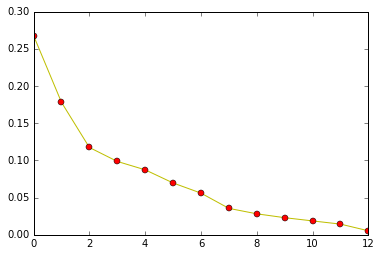

1st eigenvector:  [-0.24095407 -0.31073604 -0.17321271  0.32535422 -0.1440973   0.49353427
 -0.24291178  0.1482702  -0.34819982  0.22635421  0.06058389 -0.43164237
 -0.04160593]
10th eigenvector: [-0.29310334 -0.29792185 -0.36672942  0.24309294 -0.15763441 -0.20877011
  0.25291904  0.03262914 -0.26627004 -0.24233787 -0.00570133  0.50995463
 -0.32949731] 

(13, 13) (13, 13)
Using 50 samples for training:


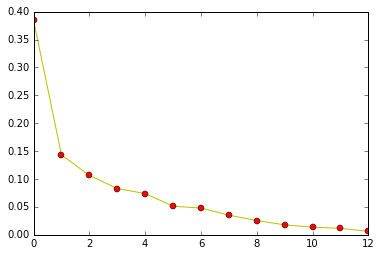

1st eigenvector:  [-0.36365031 -0.06596783  0.06640726 -0.37919819  0.01298491 -0.20363257
  0.08400938 -0.27219092  0.17266352 -0.2986417  -0.25074968  0.63945648
  0.04056656]
10th eigenvector: [-0.37705163 -0.06120419  0.23108038 -0.22208626  0.00629542  0.24401073
  0.00525288 -0.06298604  0.04918697 -0.31494044  0.62873942 -0.26233893
  0.34935391] 



In [1084]:
#Analyze the wine-database first
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

def getTrainingData(iteration, data):
    if iteration == 0:
        trainingData = [data[0].sample(5), data[1].sample(55)]
    elif iteration == 1:
        trainingData = [data[0].sample(50), data[1].sample(50)]
    elif iteration == 2:
        trainingData = [data[0].sample(50), data[1].sample(50)]
    return trainingData

## Change this to location of data-bases
wineDataPath = "data/wine.data"
headers = ['Lab','Alc','Ma','Ash','Alk','Mag','Phe','Fla','NoFla','Pro','Col','Hue','OD','Pr']
readData = pandas.read_csv(wineDataPath, names=headers)
data = [(readData[readData['Lab'] == 1]), (readData[readData['Lab'] == 2])]
eigenValues, eigenVectors, mean, deviation = [],[],[],[]

identificationStrings = ["5 samples", "50 samples", "10-fold cross validation"]
for iteration in range(0,2):
    trainingData = getTrainingData(iteration, data)
    trainingLabels = [trainingData[0].Lab, trainingData[1].Lab]
    trainingDataUnlabeled = [trainingData[0].drop('Lab', axis=1), trainingData[1].drop('Lab', axis=1)]
    totalTrainingData = trainingDataUnlabeled[0].append(trainingDataUnlabeled[1]) 

    testingData = [classData[0].drop(trainingData[0].index), classData[1].drop(trainingData[1].index)]
    testingLabels = [testingData[0].Lab, testingData[1].Lab]
    testingDataUnlabeled = [testingData[0].drop('Lab', axis=1), testingData[1].drop('Lab', axis=1)]

    eValues, eVectors = PCA(totalTrainingData.as_matrix())
    eigenValues.append(eValues)
    eigenVectors.append(eVectors)
    mean.append(totalTrainingData.mean())
    centeredData = totalTrainingData - totalTrainingData.mean()
    deviation.append(centeredData.std(axis = 0))

    print("Using %s for training:" %(identificationStrings[iteration]))
    VisualizeCumulativeSum( eigenValues[iteration] )
    print("1st eigenvector: ", VisualizeEigenVector( eigenVectors[iteration], 0 ))
    print("10th eigenvector:", VisualizeEigenVector( eigenVectors[iteration], 9 ), "\n")


I also use a variable number of eigenvectors for the reconstruction, discarding those for which the ratio: (eigenvalue)/(sum of eigenvalues) falls below a threshhold (I use a threshhold of 0.03). Using this to reconstruct a test-example, I get the following reconstruction errors:

In [ ]:
#Analyze wine data
testingSample = testingDataUnlabeled[np.random.randint(0, high=len(testingDataUnlabeled))].sample()
threshhold = 0.03

for iteration in range(0,len(eigenValues)):   
    print("When using %s for training:" %(identificationStrings[iteration]))
    sumValues = eigenValues[iteration].sum()
    scaledValues = eigenValues[iteration]/sumValues
    for j in range(0,eigenValues[iteration].shape[0]):
        if scaledValues[j] < threshhold:
            break

    #First normalize and center-mean the sample
    centeredSample = testingSample - mean[iteration]
    normalizedSample = centeredSample / deviation[iteration]

    #Decide number of eigenvectors to use
    numToUse = j+1
    #if TEST_MODE:
       #Use all eigenVectors and see that reconstruction error is zero
       #numToUse = eigenValues[i].shape[0] 
    print("Number of eigenvectors being used ", numToUse)
    
    basis = eigenVectors[iteration][:,:numToUse].T
    projection = basis.dot(normalizedSample.T)
    reconstruction = (basis.T.dot(projection)).T

    #if TEST_MODE:
    #    assert(np.allclose(np.linalg.norm(basis[:,0]), 1)) #Unit basis
    #    assert(np.allclose(basis[:,1].dot(basis[:,5].T), 0)) #Orthogonal basis
    #    assert(np.allclose(reconstruction - normalizedSample, 0)) #Complete reconstruction

    print("Reconstruction error:", np.linalg.norm(reconstruction - normalizedSample), "\n")

In [ ]:
    #Train
    trainingMeans = [trainingDataUnlabeled[0].mean(), trainingDataUnlabeled[1].mean()]
    trainingVariance = totalTrainingData.var()
    weights = (trainingMeans[1]*trainingMeans[1] - trainingMeans[0]*trainingMeans[0])/trainingVariance
    bias = 0.5 + ((trainingMeans[1]*trainingMeans[1] - trainingMeans[0]*trainingMeans[0])/2*trainingVariance).sum()

    #Test
    #for i in testingData[1].index[0:1]:
    #    data = testingData[1].ix[i]
    #    print(weights, data)
    #    label = 0 if weights.dot(data) > 0 else 1

In [1086]:
#Analyze mnist
import numpy as np
import pandas
import matplotlib.pyplot as plt

## Change this to location of data-bases
mnistTrainDataPath = "data/train.csv"
mnistTestDataPath = "data/test.csv"

readData = pandas.read_csv(mnistTrainDataPath, header=None)
readData = readData.transpose()

In [ ]:
import matplotlib.image as mpimg

#readData.
data = [(readData[readData[784] == 0]), (readData[readData[784] == 1])]
eigenValues, eigenVectors, mean, deviation = [],[],[],[]

iteration = 0
trainingData = getTrainingData(iteration, data)
trainingLabels = [trainingData[0][784], trainingData[1][784]]
trainingDataUnlabeled = [trainingData[0].drop(trainingData[0].columns[784], axis=1), 
                         trainingData[1].drop(trainingData[1].columns[784], axis=1)]
totalTrainingData = trainingDataUnlabeled[0].append(trainingDataUnlabeled[1]) 

#image = totalTrainingData[3:4]
#plt.imshow(image.as_matrix().reshape(28,28).T, origin='upper')

#testingData = [classData[0].drop(trainingData[0].index), classData[1].drop(trainingData[1].index)]
#testingLabels = [testingData[0].Lab, testingData[1].Lab]
#testingDataUnlabeled = [testingData[0].drop('Lab', axis=1), testingData[1].drop('Lab', axis=1)]

eValues, eVectors = PCA(totalTrainingData.as_matrix())
eigenValues.append(eValues)
eigenVectors.append(eVectors)
mean.append(totalTrainingData.mean())
centeredData = totalTrainingData - totalTrainingData.mean()
deviation.append(centeredData.std(axis = 0))

print(eigenVectors[0].shape)
print("Using %s fototalTrainingDatar training:" %(identificationStrings[iteration]))
VisualizeCumulativeSum( eigenValues[iteration] )
print("1st eigenvector: ")
plt.subplots(1)
VisualizeEigenImage( eigenVectors[iteration], 0 )
plt.show()
print("10th eigenvector:")
plt.subplots(1)
VisualizeEigenImage( eigenVectors[iteration], 9 )
plt.show()

In [ ]:
array1 = np.array([[1,2,3],[0, 1, 2]])
array2 = np.array([0, 1, 1])
result = array1/array2
result[:,array2 == 0] = 0
print(result)